In [879]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    VotingClassifier, AdaBoostClassifier

# Binary Classification on Titanic Dataset

## Big Picture

**Objective**: Predict if a passenger survived or not.<br>
**Problem type**: Supervised machine learning.<br>
**Performance measure**: Accuracy<br>
**Assumptions**:<br>

    1. Missing Cabins = person didn't have a cabin (lower class)
    2. 'Ticket' feature is probably obsolete, so we do not include it into our models in any way

## Get the Data

* Data is stored in *"data/titanic"* folder
* Data is divided into two files: *train.csv* and *test.csv*
* Training data contains ground-truth on passenger survival (labelled)
* Test data has no ground-truth on passenger survival (unlabelled)

In [2]:
tit_train = pd.read_csv('data/titanic/train.csv', header=0)
tit_test = pd.read_csv('data/titanic/test.csv', header=0)

## Explore the Data (EDA)

In [4]:
tit_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [30]:
tit_test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [5]:
print('Titanic train DF dimensions: {}'.format(tit_train.shape))
print('Titanic test DF dimensions: {}'.format(tit_test.shape))

Titanic train DF dimensions: (891, 12)
Titanic test DF dimensions: (418, 11)


In [6]:
tit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
tit_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


* 3 features that contan NaN's for training set:
    * **Age**
    * **Cabin**
    * **Embarked**
    
* 3 features that contan NaN's for test set:
    * **Age**
    * **Cabin**
    * **Fare**

### Examine missing values

In [17]:
def show_missing(df, feature, nr_of_rows=None):
    df_with_missing = df[df[feature].isna().head(nr_of_rows)]
    print("{} {} missing values:".format(len(df_with_missing), feature))
    return df_with_missing

show_missing(tit_train, 'Embarked')

2 Embarked missing values:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [20]:
show_missing(tit_test, 'Fare')

1 Fare missing values:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


### Describe relevant features

In [21]:
tit_train.drop(['PassengerId', 'Survived'], axis='columns').describe().round(2)

,Pclass,Age,SibSp,Parch,Fare
count,891.00,714.00,891.00,891.00,891.00
mean,2.31,29.70,0.52,0.38,32.20
std,0.84,14.53,1.10,0.81,49.69
min,1.00,0.42,0.00,0.00,0.00
25%,2.00,20.12,0.00,0.00,7.91
50%,3.00,28.00,0.00,0.00,14.45
75%,3.00,38.00,1.00,0.00,31.00
max,3.00,80.00,8.00,6.00,512.33


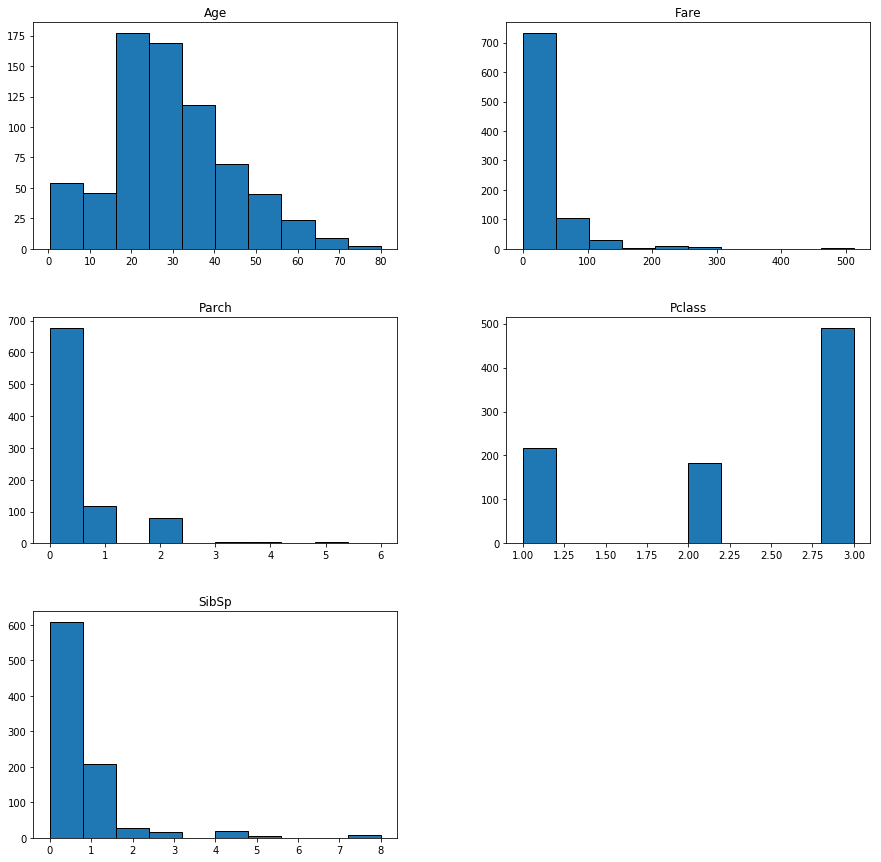

In [22]:
tit_train.drop(['PassengerId', 'Survived'], axis='columns').hist(figsize=(15,15), grid=False, edgecolor='k')
plt.show()

#### Rebinning Age feature

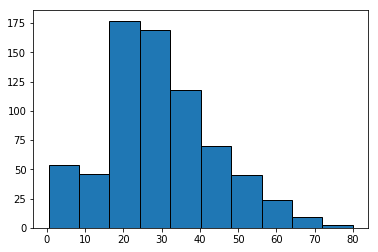

In [23]:
tit_train.Age.hist(grid=False, edgecolor='k')
plt.show()

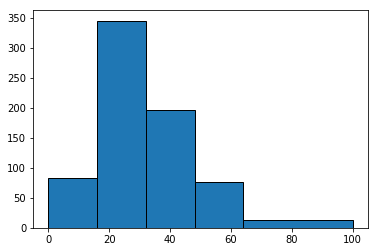

In [24]:
tit_train.Age.hist(grid=False, bins=[0.0, 16.0, 32.0, 48.0, 64.0, 100.0], edgecolor='k')
plt.show()

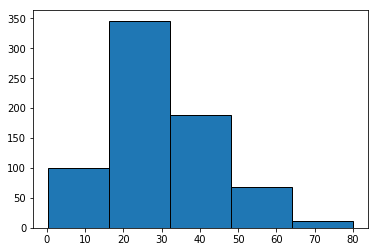

In [25]:
tit_train.Age.hist(grid=False, bins=5, edgecolor='k')
plt.show()

In [64]:
tit_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Preprocesing Data

1. Drop: *Name*, *Ticket*, *Cabin*
2. Imbute: 
    * Train: *Age*, *Embarked*
    * Test: *Age*, *Fare*
3. Dummify: *Pclass*, *Sex*, *SibSp*, *Parch* *Embarked*

Extra (later):
1. Select titles from the names Mr. Mrs. Miss. Dr. etc
2. Do not drop Cabin
3. Rebin: *Age* into 5 categories, *Fare*, *SibSp*

### Dropping features

In [27]:
drop_features = ['Name', 'Ticket', 'Cabin']
tit_train_2 = tit_train.drop(drop_features, axis='columns')
tit_test_2 = tit_test.drop(drop_features, axis='columns')

In [29]:
print(tit_train.shape, tit_train_2.shape)
print(tit_test.shape, tit_test_2.shape)

(891, 12) (891, 9)
(418, 11) (418, 8)


### Remapping features

In [76]:
print("Unique values for 'Sex': {}".format(tit_train_2.Sex.unique()))
print("Unique values for 'Embarked': {}".format(tit_train_2.Embarked.unique()))

Unique values for 'Sex': ['male' 'female']
Unique values for 'Embarked': ['S' 'C' 'Q' nan]


In [77]:
for df in [tit_train_2, tit_test_2]:
    df['Sex'] =  df['Sex'].map({'male':1, 'female':0})
    df['Embarked'] = df['Embarked'].map({'S':0, 'C':1, 'Q':2, np.nan:np.nan})

### Imputing features 

In [79]:
def impute_features(df, strategy='most_frequent'):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    return pd.DataFrame(data=imputer.fit_transform(df.values), 
                        index=None,
                        columns=df.columns.values)

In [80]:
tit_train_3 = impute_features(tit_train_2)
tit_test_3 = impute_features(tit_test_2)

In [81]:
tit_test_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null float64
Pclass         418 non-null float64
Sex            418 non-null float64
Age            418 non-null float64
SibSp          418 non-null float64
Parch          418 non-null float64
Fare           418 non-null float64
Embarked       418 non-null float64
dtypes: float64(8)
memory usage: 26.2 KB


## First model run

In [83]:
tit_train_3.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,0.0,3.0,1.0,22.0,1.0,0.0,7.2500,0.0
1,2.0,1.0,1.0,0.0,38.0,1.0,0.0,71.2833,1.0


In [85]:
# features to use on the model
model_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'
tit_train_3[model_features].head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3.0,1.0,22.0,1.0,0.0,7.2500,0.0
1,1.0,0.0,38.0,1.0,0.0,71.2833,1.0


### Crate model

In [86]:
clf = LogisticRegression(solver='liblinear')
clf.fit(X=tit_train_3[model_features], y=tit_train[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

### Predictions

In [88]:
predictions = clf.predict(tit_test_3[model_features])
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### Create .csv of 'PassengerId' and 'Survived'

In [93]:
sub_df = pd.DataFrame(data={'PassengerId':tit_test_3['PassengerId'],
                            'Survived':predictions}, dtype=np.int64)
sub_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [91]:
sub_df.shape

(418, 2)

In [94]:
prepath = 'data/titanic/submissions/'
sub_df.to_csv(prepath + 'titanic_predictions_1.csv', index=False)
# 0.75119 accuracy

## Automating preprocessing

What we would like to do:
* Create a pipeline on a DF
* Each specified column or series of columns will get their own transformations:
    * Dropping
    * Rebinning
    * Imputing 
    * Dummifying

In [95]:
# starting from the raw data
train = pd.read_csv('data/titanic/train.csv', header=0)
test = pd.read_csv('data/titanic/test.csv', header=0)

In [96]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


Order of preprocessing:
1. Dropping columns we do not want or selecting columns we want
2. Imputing missing values
3. Rebinning 
4. Dummifying

### Feature Selector

* Build an sklearn class that takes DF as input 
* Selects specified columns
* Comes handy if no preprocessing has to be done for a feature

In [155]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.features != None:
            return X[self.features]
        else:
            return X[X.columns.values]

In [158]:
train_x = FeatureSelector(['Survived', 'Sex']).fit_transform(train)
train_x.head(2)

,Survived,Sex
0,0,male
1,1,female


### Feature Rebinner

* Build a sklearn class that rebins specified feature

In [867]:
class FeatureRebinner(BaseEstimator, TransformerMixin):
    def __init__(self, bins=5, edges=None):
        self.bins = bins
        self.edges = edges
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        minimum = int(train.Age.min() // 1)
        maximum = int(train.Age.max())
        step = (maximum - minimum) // self.bins
        labels = [i for i in range(self.bins)]    
        if self.edges == None:
            edges = [np.inf if ndx == self.bins else edge for ndx, edge in \
                     enumerate(range(minimum, maximum + 1, step))]
            return pd.cut(x=X[X.columns[0]], bins=edges, labels=labels).to_frame()
        else:
            if type(X) == type(np.array([])):
                X = pd.DataFrame(X)
            return pd.cut(x=X[X.columns[0]], bins=self.edges).to_frame()

Raw distribution


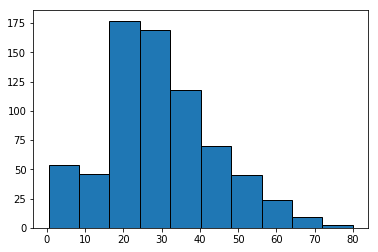

In [287]:
print('Raw distribution')
train.Age.hist(grid=False, ec='k')
plt.show()

Automatically rebinned distribution


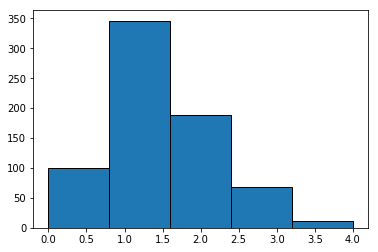

In [295]:
print('Automatically rebinned distribution')
train_x = FeatureRebinner(bins=5).fit_transform(train[['Age']])
train_x.hist(grid=False, ec='k', bins=5)
plt.show()

Manually rebinned distribution


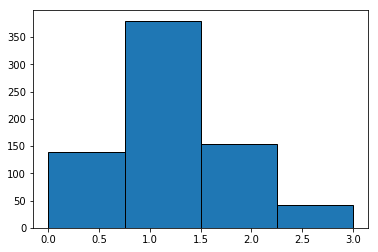

In [299]:
print('Manually rebinned distribution')
train_x = FeatureRebinner(bins=4, edges=[0, 18, 36, 54, np.inf]).fit_transform(train[['Age']])
train_x.hist(grid=False, ec='k', bins=4)

### Feature Remapper

* Re-categorizes features with skewed classes

In [307]:
test.Parch.value_counts()

0    324
1     52
2     33
3      3
9      2
4      2
6      1
5      1
Name: Parch, dtype: int64

In [598]:
class FeatureRemapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_classes=3):
        self.n_classes = n_classes
    def fit(self, X, y=None):
        self._columns = X.columns.values
        return self
    def transform(self, X, y=None):
        EX = pd.DataFrame()
        for feature in self._columns:
            EX[feature] = np.where(X[feature] >= self.n_classes, self.n_classes - 1, X[feature])
        return EX.values

### Short-listing models

In [817]:
# function to measure estimator performance 
def test_model(estimator, preds=False):
    """Outputs specified estimator performance with cv=3. If
    preds=True returns predictions on a Titanic test set."""
    cv_scores = cross_val_score(estimator, X=train_prepped, y=train['Survived'], cv=3)
    
    print('{} accuracy: {:.3f} (+/- {:.3f})'.format(
        estimator.__class__.__name__,
        cv_scores.mean(), cv_scores.std() * 2))
    if preds == True:
        clf = estimator.fit(train_prepped, train['Survived'])
        return clf.predict(test_prepped)
    else:
        pass

In [33]:
# testing Support Vector Machine
test_model(SVC(gamma='auto'))

SVC accuracy: 0.808 (+/- 0.048)


In [815]:
# let's tune SVM parameters
param_grid = {'C': np.linspace(110, 175, 10),
              'gamma': np.linspace(0.001, 0.02, 10)}

svm = SVC(kernel='rbf',random_state=0)

svm_grid = GridSearchCV(svm, param_grid, cv=5, iid=False,
                        return_train_score=False, n_jobs=-1).fit(train_prepped, train['Survived'])

print('LogistiCregression best parameters: {}'.format(svm_grid.best_params_))
print('Best accuracy score: {:.3f}'.format(svm_grid.best_score_))

LogistiCregression best parameters: {'C': 160.55555555555554, 'gamma': 0.007333333333333333}
Best accuracy score: 0.832


In [531]:
# testing LinearSVC
test_model(LinearSVC(max_iter=10000))

LinearSVC accuracy: 0.790 (+/- 0.037)


In [532]:
# testing random forest
test_model(RandomForestClassifier(n_estimators=100))

RandomForestClassifier accuracy: 0.796 (+/- 0.047)


In [533]:
# testing LogisticRegression
test_model(LogisticRegression(solver='liblinear'))

LogisticRegression accuracy: 0.795 (+/- 0.039)


## Second model run

In [309]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [911]:
cat_imp = ['Pclass', 'Sex', 'Embarked']
cat_remap = ['SibSp', 'Parch']
num_age = ['Age']
num_fare = ['Fare']

ct = ColumnTransformer([
    ('cat_imp_enc', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_imp),
    ('cat_remap', Pipeline([
        ('remapper', FeatureRemapper()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_remap),
    ('age_rebin_imp', Pipeline([
        ('rebinner', FeatureRebinner(bins=5)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), num_age),
    ('fare_imp_scale', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_fare)
])

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

lr = LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=7)
lsvc = LinearSVC(C=0.07, random_state=7)
svc = SVC(kernel='rbf', C=160, gamma=0.0073, random_state=7, probability=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
    min_samples_split=15, random_state=7)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    min_samples_split=20, max_depth=4, random_state=7)
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

ensemble_clf = VotingClassifier([('lr', lr),('svc', svc),('knn', knn),
                                 ('rf', rf),('gb', gb_clf)], voting='soft')

clfs = [lr, lsvc, rf, gb, knn, ensemble_clf]
for clf in clfs:
    test_model(clf)

LogisticRegression accuracy: 0.787 (+/- 0.006)
LinearSVC accuracy: 0.791 (+/- 0.016)
RandomForestClassifier accuracy: 0.799 (+/- 0.049)
GradientBoostingClassifier accuracy: 0.799 (+/- 0.035)
KNeighborsClassifier accuracy: 0.779 (+/- 0.006)
VotingClassifier accuracy: 0.808 (+/- 0.010)


In [810]:
pred = test_model(LogisticRegression(solver='liblinear'))

LogisticRegression accuracy: 0.795 (+/- 0.039)


In [524]:
def submit_model(predictions, file_number):
    print('Creating submission DF:\n')
    submission_df = pd.DataFrame(data={'PassengerId':test['PassengerId'],
                                      'Survived':predictions}, dtype=np.int64)
    print('DF shape: {}'.format(submission_df.shape))
    prepath = 'data/titanic/submissions/titanic_predictions_'
    submission_df.to_csv(prepath + str(file_number) + '.csv', index=False)
    print('{} file created.'.format('titanic_predictions_' + str(file_number) + '.csv'))

In [525]:
submit_model(pred, 2)

Creating submission DF:

DF shape: (418, 2)
titanic_predictions_2.csv file created.


## Hyperparameter tuning

In [592]:
# function for hyperparameter tuning. Outputs best
# accuracy at best parameters
def tune_hyper(estimator, param_grid, X, y, cv=5, n_jobs=-1):
    grid = GridSearchCV(estimator, param_grid, cv=cv, iid=False,
                        return_train_score=False, n_jobs=-1).fit(X, y)
    
    print('GridSearchCV results for {}:\n'.format(estimator.__class__.__name__))
    print('Best accuracy score: {:.3f}'.format(grid.best_score_))
    
    best_param_dict = {k:(round(v, 2)) if type(v) == float else v \
                       for (k, v) in grid.best_params_.items()}
    print('Best parameters: {}'.format(best_param_dict))

In [600]:
tune_hyper(LogisticRegression(solver='liblinear', random_state=6), 
           param_grid={'penalty':['l1', 'l2'], 
                       'C': np.arange(25, 40)},
           X=train_prepped, y=train['Survived'])

GridSearchCV results for LogisticRegression:

Best accuracy score: 0.791
Best parameters: {'C': 25, 'penalty': 'l1'}


In [588]:
test_model(RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=5,
                                  min_samples_leaf=8))

RandomForestClassifier accuracy: 0.804 (+/- 0.044)


In [593]:
tune_hyper(estimator=RandomForestClassifier(n_estimators=50), 
           param_grid={'max_depth': np.arange(1,10),
                       'min_samples_split': np.arange(2,10),
                       'min_samples_leaf': np.arange(4,10)},
           X=train_prepped, y=train['Survived'])

GridSearchCV results for RandomForestClassifier:

Best accuracy score: 0.820
Best parameters: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 9}


In [597]:
# submit randomforestclassifer model to kaggle
preds = test_model(RandomForestClassifier(n_estimators=100, max_depth=5,
                                          min_samples_leaf=5, min_samples_split=9),
                   preds=True)
submit_model(predictions=preds, file_number=3)

RandomForestClassifier accuracy: 0.811 (+/- 0.038)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_3.csv file created.


In [706]:
tune_hyper(LinearSVC(), 
           param_grid={'C': np.logspace(-3, -1, 200)},
           X=train_prepped, y=train['Survived'])

GridSearchCV results for LinearSVC:

Best accuracy score: 0.811
Best parameters: {'C': 0.06905513520162328}


## Extra Feature-Engineering

1. Change *SibSp* and *Parch* mapping:
    * before we had 3 classes, 0, 1 and +1
    * now lets try classes 0 and any
2. Playing around with 'Age' rebinning   
2. Try extracting name titles from the names
3. Eperiment rebinning and categorizing fare fature
4. Experiment with cabin amounts, and letters

### Chaning 'SibSp' and 'Parch' mapping from 3 classes to 2

In [602]:
# before feature engineering
test_model(LogisticRegression(penalty='l1', C=25, solver='liblinear'))

LogisticRegression accuracy: 0.795 (+/- 0.043)


In [912]:
# remap the 'SibSp' and 'Parch' from 3 classes to two
cat_imp = ['Pclass', 'Sex', 'Embarked']
cat_remap = ['SibSp', 'Parch']
num_age = ['Age']
num_fare = ['Fare']

ct = ColumnTransformer([
    ('cat_imp_enc', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_imp),
    ('cat_remap', Pipeline([
        ('remapper', FeatureRemapper(n_classes=2)),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_remap),
    ('age_rebin_imp', Pipeline([
        ('rebinner', FeatureRebinner(bins=5)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), num_age),
    ('fare_imp_scale', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_fare)
])

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

lr = LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=7)
lsvc = LinearSVC(C=0.07, random_state=7)
svc = SVC(kernel='rbf', C=160, gamma=0.0073, random_state=7, probability=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
    min_samples_split=15, random_state=7)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    min_samples_split=20, max_depth=4, random_state=7)
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

ensemble_clf = VotingClassifier([('lr', lr),('svc', svc),('knn', knn),
                                 ('rf', rf),('gb', gb_clf)], voting='soft')

clfs = [lr, lsvc, rf, gb, knn, ensemble_clf]
for clf in clfs:
    test_model(clf)

LogisticRegression accuracy: 0.791 (+/- 0.015)
LinearSVC accuracy: 0.777 (+/- 0.008)
RandomForestClassifier accuracy: 0.808 (+/- 0.034)
GradientBoostingClassifier accuracy: 0.800 (+/- 0.037)
KNeighborsClassifier accuracy: 0.787 (+/- 0.014)
VotingClassifier accuracy: 0.813 (+/- 0.006)


We lost some of the accuracy, thus we keep 3 classes for 'SibSp' and 'Parch'

### 'Age' rebinning

In [913]:
ct = ColumnTransformer([
    ('cat_imp_enc', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_imp),
    ('cat_remap', Pipeline([
        ('remapper', FeatureRemapper(n_classes=2)),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_remap),
    ('age_rebin_imp', Pipeline([
        ('rebinner', FeatureRebinner(bins=4, edges=[0.0, 8, 18, 50, np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), num_age),
    ('fare_imp_scale', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_fare)
])

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

lr = LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=7)
lsvc = LinearSVC(C=0.07, random_state=7)
svc = SVC(kernel='rbf', C=160, gamma=0.0073, random_state=7, probability=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
    min_samples_split=15, random_state=7)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    min_samples_split=20, max_depth=4, random_state=7)
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

ensemble_clf = VotingClassifier([('lr', lr),('svc', svc),('knn', knn),
                                 ('rf', rf),('gb', gb_clf)], voting='soft')

clfs = [lr, lsvc, rf, gb, knn, ensemble_clf]
for clf in clfs:
    test_model(clf)

LogisticRegression accuracy: 0.807 (+/- 0.008)
LinearSVC accuracy: 0.785 (+/- 0.016)
RandomForestClassifier accuracy: 0.810 (+/- 0.014)
GradientBoostingClassifier accuracy: 0.800 (+/- 0.066)
KNeighborsClassifier accuracy: 0.788 (+/- 0.063)
VotingClassifier accuracy: 0.807 (+/- 0.017)


### Titles from 'Name'

In [632]:
train[['Name']].head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


In [640]:
# finding name titles in trainign set
train.Name.str.extract(pat=r'(\b[A-Z][a-z]*\.)')[0].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Mme.           1
Don.           1
Sir.           1
Lady.          1
Ms.            1
Countess.      1
Jonkheer.      1
Capt.          1
Name: 0, dtype: int64

In [641]:
# finding name titles in test set
test.Name.str.extract(pat=r'(\b[A-Z][a-z]*\.)')[0].value_counts()

Mr.        240
Miss.       78
Mrs.        72
Master.     21
Col.         2
Rev.         2
Ms.          1
Dr.          1
Dona.        1
Name: 0, dtype: int64

All instances in trainign and test sets contain a title. Let's try to group them down into few general titles, special one go to tile 'Vip.'

In [643]:
title_dict = {'Mlle.': 'Miss.', 
              'Col.': 'Vip.',
              'Major.': 'Vip.',
              'Lady.': 'Mrs.',
              'Ms.': 'Miss.',
              'Capt.': 'Vip.',
              'Countess.': 'Vip.',
              'Sir.': 'Vip.',
              'Don.': 'Vip.',
              'Mme.': 'Mrs.',
              'Dona.': 'Vip.',
              'Rev.': 'Vip.',
              'Dr.': 'Vip.',
              'Jonkheer.': 'Vip.'}

In [687]:
# sklearn transformer that extarcts name titles
# from names and remaps some unique titles by
# provided dictionary
class TitleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, re_pattern=r'(\b[A-Z][a-z]*\.)', title_dict=title_dict):
        self.re_pattern = re_pattern
        self.title_dict = title_dict
    def fit(self, X, y=None):
        self.col = X.columns[0]
        return self
    def transform(self, X, y=None):
        return X[self.col].str.extract(pat=self.re_pattern).replace(to_replace=title_dict)

In [916]:
ct = ColumnTransformer([
    ('cat_imp_enc', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_imp),
    ('cat_remap', Pipeline([
        ('remapper', FeatureRemapper(n_classes=2)),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_remap),
    ('age_rebin_imp', Pipeline([
        ('rebinner', FeatureRebinner(bins=4, edges=[0.0, 8, 18, 50, np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), num_age),
    ('fare_imp_scale', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_fare),
    ('name_title', Pipeline([
        ('ext_titles', TitleExtractor()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Name'])
])

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

lr = LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=7)
lsvc = LinearSVC(C=0.07, random_state=7)
svc = SVC(kernel='rbf', C=160, gamma=0.0073, random_state=7, probability=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
    min_samples_split=15, random_state=7)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    min_samples_split=20, max_depth=4, random_state=7)

ensemble_clf = VotingClassifier([('lr', lr),('svc', svc),
                                 ('rf', rf),('gb', gb_clf)], voting='soft')

clfs = [lr, lsvc, rf, gb, ensemble_clf]
for clf in clfs:
    test_model(clf)

LogisticRegression accuracy: 0.804 (+/- 0.052)
LinearSVC accuracy: 0.799 (+/- 0.026)
RandomForestClassifier accuracy: 0.813 (+/- 0.022)
GradientBoostingClassifier accuracy: 0.820 (+/- 0.050)
VotingClassifier accuracy: 0.824 (+/- 0.018)


### Rebin and categorize 'Fare' feature

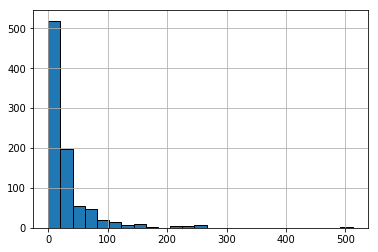

In [149]:
titanic.Fare.hist(bins=25, edgecolor='black')
plt.show()

Zoom into 100

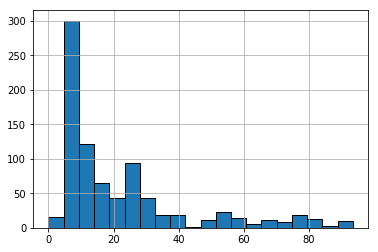

In [150]:
titanic.Fare[titanic.Fare < 100].hist(bins=20, edgecolor='black')
plt.show()

Let's try with various bins:
* (0, 10, 20, 30, 40, inf)
* (0, 25, 50, inf)

In [918]:
ct = ColumnTransformer([
    ('cat_imp_enc', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_imp),
    ('cat_remap', Pipeline([
        ('remapper', FeatureRemapper(n_classes=2)),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_remap),
    ('age_rebin_imp', Pipeline([
        ('rebinner', FeatureRebinner(bins=4, edges=[0.0, 8, 18, 50, np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), num_age),
    ('fare_imp_scale', Pipeline([
        ('rebinner', FeatureRebinner(bins=3, edges=[0,25,50,np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Fare']),
    ('name_title', Pipeline([
        ('ext_titles', TitleExtractor()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Name'])
])

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

lr = LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=7)
lsvc = LinearSVC(C=0.07, random_state=7)
svc = SVC(kernel='rbf', C=160, gamma=0.0073, random_state=7, probability=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
    min_samples_split=15, random_state=7)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    min_samples_split=20, max_depth=4, random_state=7)

knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

ensemble_clf = VotingClassifier([('lr', lr),('svc', svc),('knn', knn),
                                 ('rf', rf),('gb', gb_clf)], voting='hard')

clfs = [lr, lsvc, rf, gb, knn, ensemble_clf]
for clf in clfs:
    test_model(clf)

LogisticRegression accuracy: 0.809 (+/- 0.055)
LinearSVC accuracy: 0.809 (+/- 0.042)
RandomForestClassifier accuracy: 0.815 (+/- 0.020)
GradientBoostingClassifier accuracy: 0.820 (+/- 0.061)
KNeighborsClassifier accuracy: 0.790 (+/- 0.063)
VotingClassifier accuracy: 0.823 (+/- 0.021)


In [709]:
test_prepped = ct.fit_transform(test)

In [710]:
# submit this result with RFC
preds = test_model(RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
                                  min_samples_split=15, random_state=6), preds=True)
submit_model(preds, 4)

RandomForestClassifier accuracy: 0.816 (+/- 0.035)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_4.csv file created.


In [712]:
# submit the result with LinearSVC
preds = test_model(LinearSVC(C=0.07), preds=True)
submit_model(preds, 5)

LinearSVC accuracy: 0.809 (+/- 0.045)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_5.csv file created.


### Experiment with 'Cabin' feature

In [152]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [713]:
train[train.Cabin.notna()].Cabin.str.extract(pat=r'(\b[A-Z]{1})')[0].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: 0, dtype: int64

In [770]:
test[test.Cabin.notna()].Cabin.str.extract(pat=r'(\b[A-Z]{1})')[0].value_counts()

C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: 0, dtype: int64

In [875]:
cabin_dict = {
    'A':1,
    'B':1,
    'C':1,
    'D':1,
    'E':2,
    'F':3,
    'G':3,
    'T':3,
    'X':3
}

In [775]:
cabin_dict2 = {
    'A':1,
    'B':1,
    'C':1,
    'D':2,
    'E':3,
    'F':3,
    'G':3,
    'T':3,
    'X':3
}

In [876]:
# finds cabin letter if applicable, extracts it, replaces nans with 'X',
# converts cabins to respective classes 1,2,3. It is presumed that most
# of nans correspond to class 3 people
class CabinFormatter(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        self._columns = X.columns.values
        return self
    def transform(self, X, y=None):
        return X[self._columns[0]].apply(lambda x: x[0] if x is not np.nan else 'X')\
    .to_frame().replace(to_replace=cabin_dict)

In [851]:
class HasCabin(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        self.data = X[X.columns[0]].to_frame()
        return self
    def transform(self, X, y=None):
        return ~self.data.isna()

In [921]:
ct = ColumnTransformer([
    ('cat_imp_enc', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_imp),
    ('cat_remap', Pipeline([
        ('remapper', FeatureRemapper(n_classes=2)),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_remap),
    ('age_rebin_imp', Pipeline([
        ('rebinner', FeatureRebinner(bins=4, edges=[0.0, 8, 18, 50, np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), num_age),
    ('fare_imp_scale', Pipeline([
        ('rebinner', FeatureRebinner(bins=3, edges=[0,25,50,np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Fare']),
    ('name_title', Pipeline([
        ('ext_titles', TitleExtractor()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Name']),
    ('has_cabin', Pipeline([
        ('has', HasCabin()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Cabin'])
])

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

lr = LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=7)
lsvc = LinearSVC(C=0.07, random_state=7)
svc = SVC(kernel='rbf', C=160, gamma=0.0073, random_state=7, probability=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
    min_samples_split=15, random_state=7)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    min_samples_split=20, max_depth=4, random_state=7)

knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

ensemble_clf = VotingClassifier([('lr', lr),('svc', svc),('knn', knn),
                                 ('rf', rf),('gb', gb_clf)], voting='soft')

clfs = [lr, lsvc, rf, gb, knn, ensemble_clf]
for clf in clfs:
    test_model(clf)

LogisticRegression accuracy: 0.809 (+/- 0.041)
LinearSVC accuracy: 0.808 (+/- 0.029)
RandomForestClassifier accuracy: 0.815 (+/- 0.019)
GradientBoostingClassifier accuracy: 0.819 (+/- 0.059)
KNeighborsClassifier accuracy: 0.800 (+/- 0.014)
VotingClassifier accuracy: 0.822 (+/- 0.016)


In [726]:
# submit the result with LinearSVC
preds = test_model(LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=6), preds=True)
submit_model(preds, 6)

LogisticRegression accuracy: 0.807 (+/- 0.071)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_6.csv file created.


In [727]:
# submit the result with LinearSVC
preds = test_model(RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
                                  min_samples_split=15, random_state=6), preds=True)
submit_model(preds, 7)

RandomForestClassifier accuracy: 0.817 (+/- 0.034)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_7.csv file created.


In [732]:
# tune hyper paramters for RFC
tune_hyper(estimator=RandomForestClassifier(n_estimators=100, max_depth=4), 
           param_grid={'min_samples_split': np.arange(5,25,5),
                       'min_samples_leaf': np.arange(5, 25, 5)},
           X=train_prepped, y=train['Survived'])

GridSearchCV results for RandomForestClassifier:

Best accuracy score: 0.815
Best parameters: {'min_samples_leaf': 5, 'min_samples_split': 20}


In [739]:
# tune hyper paramters for GBC
tune_hyper(estimator=GradientBoostingClassifier(n_estimators=100), 
           param_grid={'learning_rate': [0.01],
                       'min_samples_split': [20],
                       'max_depth': [5]},
           X=train_prepped, y=train['Survived'])

GridSearchCV results for GradientBoostingClassifier:

Best accuracy score: 0.832
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 20}


In [740]:
# submit the result with GBC
preds = test_model(GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
                                              min_samples_split=20, max_depth=4), preds=True)
submit_model(preds, 9)

GradientBoostingClassifier accuracy: 0.815 (+/- 0.071)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_8.csv file created.


In [741]:
# submit the result with GBC
preds = test_model(GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
                                              min_samples_split=20, max_depth=4), preds=True)
submit_model(preds, 9)

GradientBoostingClassifier accuracy: 0.805 (+/- 0.047)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_9.csv file created.


In [774]:
# submit the result with LG
preds = test_model(LogisticRegression(penalty='l1', C=25, solver='liblinear',
                                      random_state=7), preds=True)
submit_model(preds, 10)

LogisticRegression accuracy: 0.812 (+/- 0.053)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_10.csv file created.


### Feature engineer extra features

* Sum 'SibSp' and 'Parch'

In [787]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, method='sum'):
        self.method = method
    def fit(self, X, y=None):
        self.cols = X.columns
        return self
    def transform(self, X):
        EX = pd.DataFrame()
        if self.method == 'sum':
            return (X[self.cols[0]] + X[self.cols[1]]).to_frame()
        elif self.method == 'multiply':
            return (X[self.cols[0]] + X[self.cols[1]]).to_frame()
        else:
            raise('Choose correct method.')

In [904]:
ct = ColumnTransformer([
    ('cat_imp_enc', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_imp),
    ('age_rebin_imp', Pipeline([
        ('rebinner', FeatureRebinner(bins=5, edges=[0.0, 8, 18, 50, np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), num_age),
    ('fare_imp_scale', Pipeline([
        ('rebinner', FeatureRebinner(bins=3, edges=[0,10,20,np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Fare']),
    ('name_title', Pipeline([
        ('ext_titles', TitleExtractor()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Name']),
    ('has_cabin', Pipeline([
        ('has', HasCabin()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Cabin']),
    ('f_engineer', Pipeline([
        ('f_e', FeatureEngineer(method='sum')),
        ('remapper', FeatureRemapper(n_classes=2)),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['SibSp', 'Parch'])
])

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

lr = LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=7)
lsvc = LinearSVC(C=0.07, random_state=7)
svc = SVC(kernel='rbf', C=160, gamma=0.0073, random_state=7, probability=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
    min_samples_split=15, random_state=7)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    min_samples_split=20, max_depth=4, random_state=7)
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

ensemble_clf = VotingClassifier([('lr', lr),('svc', svc), ('knn', knn),
                                 ('rf', rf),('gb', gb_clf)], voting='soft')

clfs = [lr, lsvc, knn, rf, gb, ensemble_clf]
for clf in clfs:
    test_model(clf)

LogisticRegression accuracy: 0.815 (+/- 0.043)
LinearSVC accuracy: 0.814 (+/- 0.021)
KNeighborsClassifier accuracy: 0.789 (+/- 0.078)
RandomForestClassifier accuracy: 0.805 (+/- 0.045)
GradientBoostingClassifier accuracy: 0.819 (+/- 0.062)
VotingClassifier accuracy: 0.823 (+/- 0.011)


In [883]:
ab = AdaBoostClassifier(ensemble_clf, n_estimators=50, learning_rate=0.01, random_state=7)
test_model(ab)

AdaBoostClassifier accuracy: 0.811 (+/- 0.036)


In [828]:
# submit the result with LG
preds = test_model(ensemble_clf, preds=True)
submit_model(preds, 13)

VotingClassifier accuracy: 0.835 (+/- 0.019)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_13.csv file created.


In [854]:
# submit the result with Ensemble
preds = test_model(ensemble_clf, preds=True)
submit_model(preds, 14)

VotingClassifier accuracy: 0.841 (+/- 0.025)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_14.csv file created.


In [874]:
# submit the result with Ensemble
preds = test_model(ensemble_clf, preds=True)
submit_model(preds, 15)

VotingClassifier accuracy: 0.833 (+/- 0.017)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_15.csv file created.


In [905]:
# submit the result with Ensemble
preds = test_model(ensemble_clf, preds=True)
submit_model(preds, 16)

VotingClassifier accuracy: 0.823 (+/- 0.011)
Creating submission DF:

DF shape: (418, 2)
titanic_predictions_16.csv file created.


In [885]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


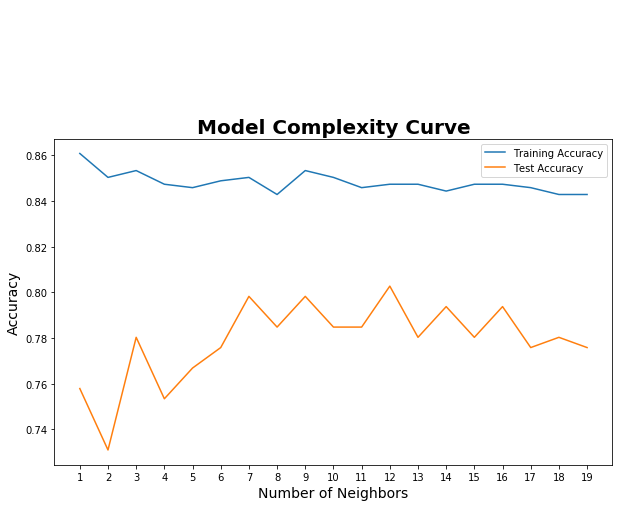

In [886]:
X_train, X_test, y_train, y_test = train_test_split(train_prepped, train['Survived'],
                                                   random_state=7)

k_values = np.arange(1, 20)
train_accuracy = np.empty(len(k_values))
test_accuracy = np.empty(len(k_values))

for i, k in enumerate(k_values):
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

plt.figure(figsize=(10, 6))
plt.title("Model Complexity Curve", fontsize=20, weight='bold')
plt.plot(k_values, train_accuracy, label="Training Accuracy")
plt.plot(k_values, test_accuracy, label="Test Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(k_values)
plt.annotate("Overfitting", xy=(16, 0.911), xytext=(11, 0.92), 
             arrowprops={'color' : 'black'}, weight='bold', fontsize=16)
plt.show()

In [887]:
tune_hyper(KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
           param_grid={'weights':['uniform', 'distance'],
                       'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
           X=train_prepped, y=train['Survived'])

GridSearchCV results for KNeighborsClassifier:

Best accuracy score: 0.821
Best parameters: {'algorithm': 'brute', 'weights': 'uniform'}


In [909]:

ct = ColumnTransformer([
    ('cat_imp_enc', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), cat_imp),
    ('age_rebin_imp', Pipeline([
        ('rebinner', FeatureRebinner(bins=4, edges=[0.0, 8, 18, 50, np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), num_age),
    ('fare_imp_scale', Pipeline([
        ('rebinner', FeatureRebinner(bins=3, edges=[0,10,20,np.inf])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Fare']),
    ('name_title', Pipeline([
        ('ext_titles', TitleExtractor()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Name']),
    ('has_cabin', Pipeline([
        ('has', HasCabin()),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['Cabin']),
    ('f_engineer', Pipeline([
        ('f_e', FeatureEngineer(method='sum')),
        ('remapper', FeatureRemapper(n_classes=2)),
        ('encoder', OneHotEncoder(categories='auto'))
    ]), ['SibSp', 'Parch'])
])

train_prepped = ct.fit_transform(train)
test_prepped = ct.fit_transform(test)

lr = LogisticRegression(penalty='l1', C=25, solver='liblinear', random_state=7)
lsvc = LinearSVC(C=0.07, random_state=7)
svc = SVC(kernel='rbf', C=160, gamma=0.0073, random_state=7, probability=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, 
    min_samples_split=15, random_state=7)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    min_samples_split=20, max_depth=4, random_state=7)
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

ensemble_clf = VotingClassifier([('lr', lr),('svc', svc), ('knn', knn),
                                 ('rf', rf),('gb', gb_clf)], voting='soft')

clfs = [lr, lsvc, knn, rf, gb, ensemble_clf]
for clf in clfs:
    test_model(clf)

LogisticRegression accuracy: 0.815 (+/- 0.043)
LinearSVC accuracy: 0.814 (+/- 0.021)
KNeighborsClassifier accuracy: 0.789 (+/- 0.078)
RandomForestClassifier accuracy: 0.805 (+/- 0.045)
GradientBoostingClassifier accuracy: 0.819 (+/- 0.062)
VotingClassifier accuracy: 0.823 (+/- 0.011)
